# Notebook 2

Marginalizing Condition

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
GENE = 'ykgE'
COND = 'Fe'
SEGMENT_SIZE = 2

In [5]:
NT_MAP = {c: i for i, c in enumerate(['A', 'C', 'G', 'T'])}


DATDIR = f"../data/expression_data/{GENE}"

# Load data corresponding to gene of interest
filelist = []
data_by_condition = {}
conditions = []
df_list = []
for fname in os.listdir(DATDIR, ):
    fpath = f"{DATDIR}/{fname}"
    if os.path.isfile(fpath) and GENE in fname:
        filelist.append(fname)
        cond = fname.removeprefix(GENE).removesuffix("dataset_alldone_with_large.txt")
        conditions.append(cond)
        df = pd.read_csv(
            fpath, sep='\\s+'
        )
        df = df.rename(columns={'seq': 'seq180'})
        df['barcode'] = df['seq180'].str.slice(160,)
        df['promoter'] = df['seq180'].str.slice(0, 160)
        df['condition'] = cond
        data_by_condition[cond] = df
        print("Loaded {} rows and {} columns for gene {} in condition {}".format(
            len(df), len(df.columns) , GENE, cond
        ))
        df_list.append(df)

DF_ALL_CONDITIONS = pd.concat(df_list)
DF_ALL_CONDITIONS

# Load wildtype data

WT_GENES_FPATH = "../data/wtsequences.csv"

wildtype_genes_df = pd.read_csv(WT_GENES_FPATH)

WT_GENE_SEQUENCES = {
    g: wildtype_genes_df.loc[wildtype_genes_df['name'] == g,'geneseq'].values[0]
    for g in wildtype_genes_df['name'].unique()
}

GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]

nbases = len(GENE_WT_SEQ)
print(f"{GENE} wildtype sequence (length {nbases}):\n", GENE_WT_SEQ)
wildtype_genes_df.head()

# Helper functions to convert sequences into numpy arrays

def gene_seq_to_array(seq, mapping):
    """Convert a string sequence to a numy array, using the provided mapping."""
    return np.array([mapping[c] for c in seq], dtype=np.uint8)

def get_sequence_arrays_and_counts(
        df, *, 
        key_promoter='promoter', 
        key_dna='ct_0', 
        key_rna='ct_1',
):
    """Convert Dataframe columns promoter, ct_0, and ct_1 to numpy arrays."""
    promoters = np.array(
        [gene_seq_to_array(s, NT_MAP) for s in df[key_promoter].values],
    )
    counts_dna = np.array(df[key_dna], dtype=int)
    counts_rna = np.array(df[key_rna], dtype=int)

    return promoters, counts_dna, counts_rna

# Convert data into numpy arrays
wt_seq = gene_seq_to_array(GENE_WT_SEQ, NT_MAP)
promoters, counts_dna, counts_rna = get_sequence_arrays_and_counts(data_by_condition[COND])

print('promoters:', promoters)
# Define expression as ratio of mRNA counts to total counts
expression = counts_rna / (counts_rna + counts_dna)

# Some helper functions to do efficienct comparisons

def compare_sequences(seq1, seq2):
    """Screen for all differing positions between seq1 and seq2.
    Supports broadcasting.
    """
    seq1 = np.broadcast_to(seq1, np.broadcast_shapes(seq1.shape, seq2.shape))
    seq2 = np.broadcast_to(seq2, np.broadcast_shapes(seq1.shape, seq2.shape))
    return seq1 != seq2

def count_mutations(seqs, wt_seq):
    mut_screen = compare_sequences(seqs, wt_seq)
    nmuts = np.sum(mut_screen, axis=-1)
    return nmuts

def compute_mean_wildtype_expression(
        sequences,
        expression,
        wt_sequence,
):
    """Mean expression when base pair j is the wildtype."""
    mut_screen = compare_sequences(sequences, wt_sequence)
    wt_screen = ~mut_screen
    num_wts = wt_screen.sum(axis=0)  # number of observed wildtype bases
    wt_counts = wt_screen * expression[:,None]
    mu_mean = wt_counts.sum(axis=0) / num_wts
    assert mu_mean.shape == (len(wt_sequence),), "Bad shape"
    return mu_mean


wt_avg_expression = compute_mean_wildtype_expression(
    promoters, expression, wt_seq
)


def compute_mean_expression_shift(
        sequences,
        expression,
        wt_seq,
):
    """Compute the average change in expression level resulting from a mutation.

    The expression shift at position j of a given sequence is the difference
    between the expression level associated with that sequence and the average
    expression level across all sequences with the wild type at position j.
    The mean expression shift if the average of this quantity, computed across
    all sequences with a mutation at position j.

    """
    wt_mean_expression = compute_mean_wildtype_expression(
        sequences, expression, wt_seq
    )

    nseqs, nbases = sequences.shape
    mut_screen = compare_sequences(sequences, wt_seq)
    
    # shifts[i,j] is the difference between expression associated with sequence i 
    # and the mean expression level when position j is WT.
    shifts = expression[:,None] - wt_mean_expression[None,:]
    assert shifts.shape == (nseqs, nbases)
    
    # Want to average shift values over only the mutations at each base
    mean_expression_shift = (mut_screen * shifts).sum(0) / mut_screen.sum(0)

    return mean_expression_shift

xi = compute_mean_expression_shift(
    promoters, expression, wt_seq
)

def get_segments(sequences, segment_size, startpos=0, stride=None):
    """Splice a given set of sequences into segments.
    """
    if np.ndim(sequences) == 1:
        sequences = sequences[None,:]
    if stride is None:
        stride = segment_size
    nseqs, nbases = sequences.shape
    starts = np.arange(startpos, nbases, stride)
    if starts[-1] + segment_size > nbases:
        starts = starts[:-1]
    segments = np.array(
        [np.arange(startidx, startidx + segment_size) for startidx in starts]
    )
    return segments


def compute_segmented_mean_expression(
        sequences,
        expression,
        wt_seq,
        segment_size,
):
    """Compute the average expression level resulting from a mutation,
    across segments of a fixed size.

    """
    nseqs, nbases = sequences.shape
    mut_screen = compare_sequences(sequences, wt_seq)

    segments = get_segments(sequences, segment_size, 0, segment_size)

    nsegments = segments.shape[0]

    mut_screen_over_segments = np.array(
        [mut_screen[i,segments] for i in range(nseqs)]
    )

    # Each length k segment's binary string mutation profile corresponds to an 
    # index in [0, 2**k).
    nidxs = 2**segment_size
    weights = 1 << np.arange(segment_size)[::-1]
    mutation_profiles = mut_screen_over_segments @ weights

    # We now need to loop over the segments, and compute the expression.
    mean_exp_by_index = np.zeros([nidxs, nsegments])
    for mutidx in range(nidxs):
        idx_screen = mutation_profiles == mutidx
        mean_exp_by_index[mutidx] = np.sum(
            idx_screen * expression[:,None],
            axis=0
        ) / idx_screen.sum(0)

    return mean_exp_by_index

#Binning Data
def binary_arr_to_int(bin_arr):
    k = bin_arr.shape[-1]
    weights = 1 << np.arange(k)[::-1]
    return bin_arr @ weights

def int_to_binary_arr(int_array, n=None):
    if not isinstance(int_array, np.ndarray):
        int_array = np.array(int_array)
    if n is None:
        n = np.max([int_array.max(), 1]).item().bit_length()
    return ((int_array[...,None] >> np.arange(n - 1, -1, -1)) & 1).astype(np.uint8)

mean_exp_by_index = compute_segmented_mean_expression(
    promoters, expression, wt_seq, segment_size=SEGMENT_SIZE,
)

#Plotting Expression
def plot_data(
        values, 
        segment_size=1, 
        bin_size=1,
        seq_start=None,
        ylabel=None,
):
    """Convenience plotting function for binned, colored bar plots."""
    fig, ax = plt.subplots(1, 1)
    
    # Bin data
    num_bins = len(values) // bin_size
    binned_vals = [
        np.mean(values[i*bin_size:(i+1)*bin_size]) for i in range(num_bins)
    ]

    # Generate x values for binned data
    x = np.arange(num_bins) * bin_size * segment_size

    colors = ['red' if value < 0 else 'blue' for value in binned_vals]
    bin_width = bin_size * segment_size
    ax.bar(x, binned_vals, width=bin_width, color=colors, align='edge')

    # Set the x-axis labels according to the given sequence interval
    if seq_start is not None:
        xticks = ax.get_xticks()
        new_labels = xticks.astype(int) + seq_start
        ax.xaxis.set_major_locator(plt.FixedLocator(xticks))
        ax.set_xticklabels(new_labels)
    
    ax.set_xlabel('position')
    ax.set_ylabel(ylabel)

    return ax




Loaded 639 rows and 7 columns for gene ykgE in condition deoR
Loaded 3971 rows and 7 columns for gene ykgE in condition 0cAMP
Loaded 4558 rows and 7 columns for gene ykgE in condition Tre
Loaded 5538 rows and 7 columns for gene ykgE in condition xylara
Loaded 913 rows and 7 columns for gene ykgE in condition arcA
Loaded 3728 rows and 7 columns for gene ykgE in condition M9
Loaded 4836 rows and 7 columns for gene ykgE in condition Anaero
Loaded 753 rows and 7 columns for gene ykgE in condition 500cAMP
Loaded 5533 rows and 7 columns for gene ykgE in condition xanth2
Loaded 5722 rows and 7 columns for gene ykgE in condition LB
Loaded 5823 rows and 7 columns for gene ykgE in condition heat
Loaded 5232 rows and 7 columns for gene ykgE in condition deltaYieP
Loaded 5557 rows and 7 columns for gene ykgE in condition metal
Loaded 4848 rows and 7 columns for gene ykgE in condition Fe
ykgE wildtype sequence (length 160):
 TCGATTTCCCCATAAAATGTGAGCGATGCCGAAAGAAATAAAATTAGTTATTGCATTTGACGTTTGGATGAAAG

In [6]:
#Compute expression shift as a function of condition


def generate_xi(COND, GENE):
    """
    Compute expression shifts at the (0,0), (0,1), (1,0), (1,1) levels for an input condition. 
    """
    
    GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]
    wildtype_genes_df.head()
    # Convert data into numpy arrays
    wt_seq = gene_seq_to_array(GENE_WT_SEQ, NT_MAP)
    promoters, counts_dna, counts_rna = get_sequence_arrays_and_counts(data_by_condition[COND])

    # Define expression as ratio of mRNA counts to total counts
    expression = counts_rna / (counts_rna + counts_dna)

    mean_exp_by_index = compute_segmented_mean_expression(
        promoters, expression, wt_seq, segment_size=SEGMENT_SIZE,
    )
    xi = mean_exp_by_index - mean_exp_by_index[0]
    
    return xi
    

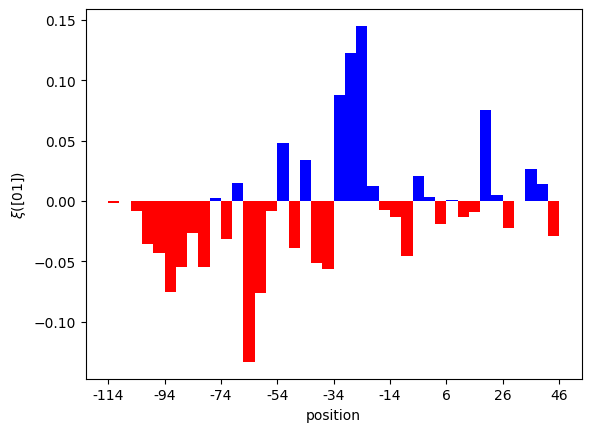

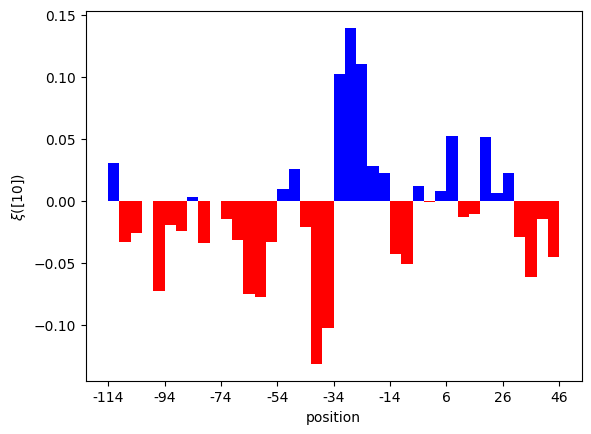

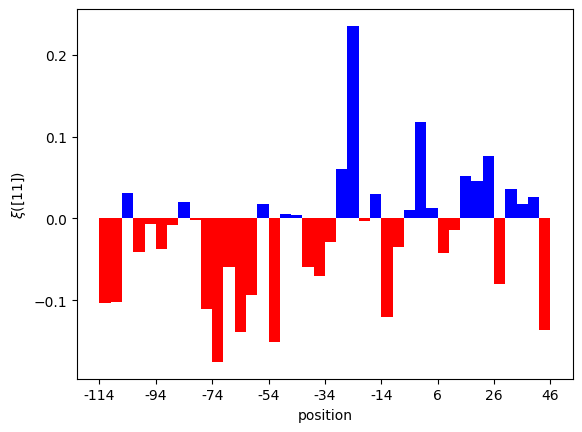

[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000

In [7]:


xi = generate_xi('Tre', 'ykgE')
for i in range(1, len(xi)):

    vals_to_plot = xi[i]
    ax = plot_data(
        vals_to_plot, 
        bin_size=2, 
        segment_size=SEGMENT_SIZE, 
        seq_start=-114,
    )
    ax.set_ylabel(f"$\\xi({int_to_binary_arr(i, SEGMENT_SIZE)})$");
    plt.show()
    
print(xi)


# Plot the Mean and Max of xi, marginalized across conditions

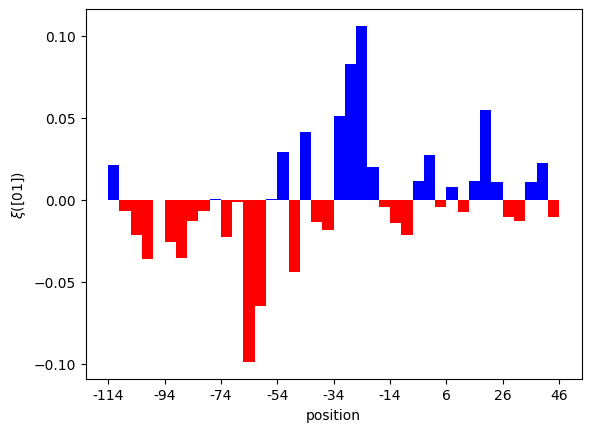

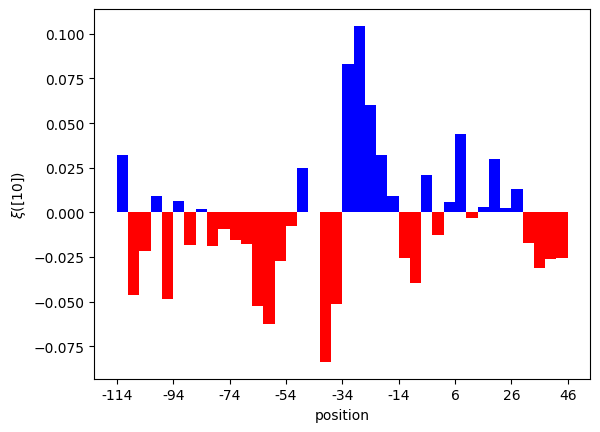

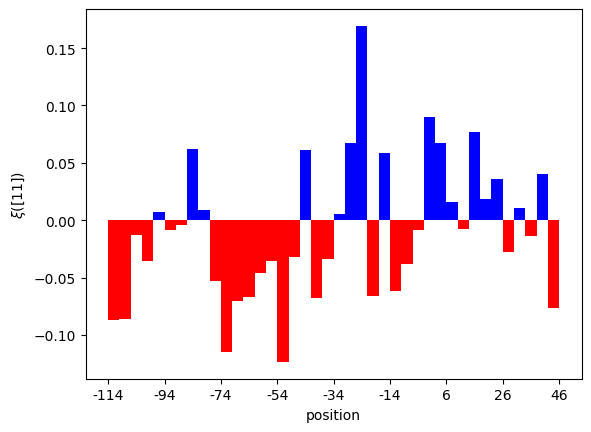

In [8]:
xi_list = []
eta = np.zeros_like(xi)
# Compute and plot eta as the mean of xi across conditions
for COND in conditions:
    eta += generate_xi(COND, 'ykgE')/len(conditions)

for i in range(1, len(xi)):
    
    vals_to_plot = eta[i]
    ax = plot_data(
        vals_to_plot, 
        bin_size=2, 
        segment_size=SEGMENT_SIZE, 
        seq_start=-114,
    )
    ax.set_ylabel(f"$\\xi({int_to_binary_arr(i, SEGMENT_SIZE)})$");
    plt.show()

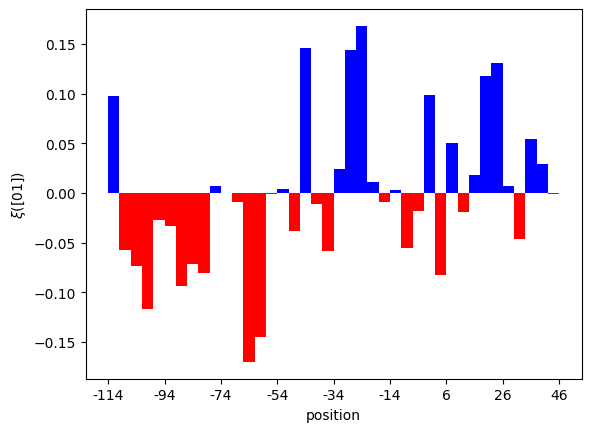

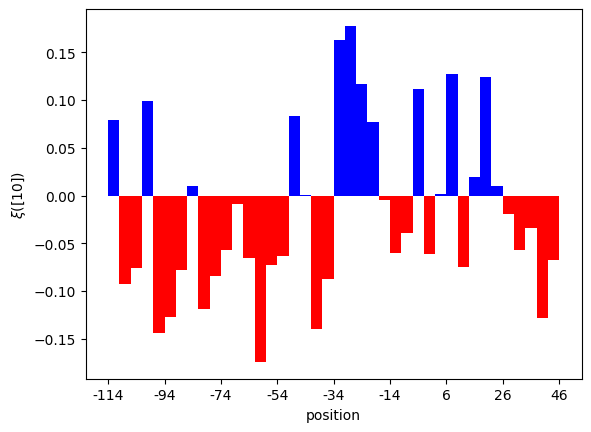

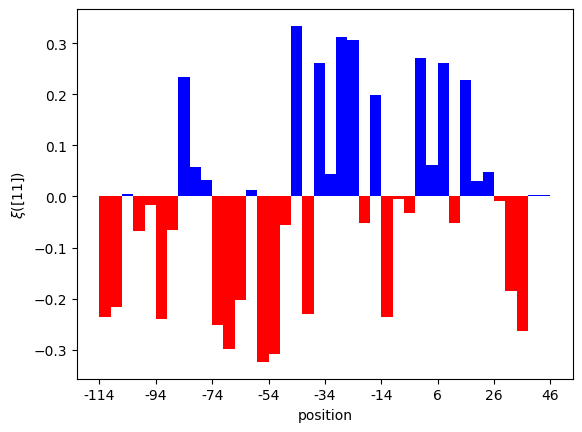

In [9]:
num_conditions = len(conditions)

# Generate xi for each condition and store in the list
xi_list = []
for COND in conditions:
    xi = generate_xi(COND, 'ykgE')
    xi_list.append(xi)
    
xi_array = np.array(xi_list)  
abs_xi = np.abs(xi_array)
max_indices = np.argmax(abs_xi, axis=0)

# Use these indices to select the corresponding values from the original xi
eta = np.take_along_axis(xi_array, max_indices[np.newaxis, ...], axis=0).squeeze(axis=0)

for i in range(1, len(xi)):
    
    vals_to_plot = eta[i]
    ax = plot_data(
        vals_to_plot, 
        bin_size=2, 
        segment_size=SEGMENT_SIZE, 
        seq_start=-114,
    )
    ax.set_ylabel(f"$\\xi({int_to_binary_arr(i, SEGMENT_SIZE)})$");
    plt.show()

# Compute $\xi$ using method 2

Text(0, 0.5, 'wildtype expression')

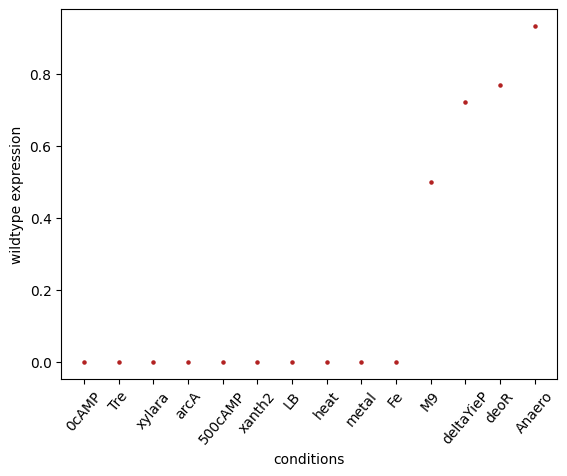

In [10]:
#Mean Expression for only the wild type barcode
#Not enough data problem...

GENE = 'ykgE'
wt_seq = gene_seq_to_array(GENE_WT_SEQ, NT_MAP)

GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]
nbases = len(GENE_WT_SEQ)
wildtype_genes_df.head()
# Convert data into numpy arrays
wt_seq = gene_seq_to_array(GENE_WT_SEQ, NT_MAP)
wt_exp = np.zeros(len(conditions))

for j in range(len(conditions)):
    promoters, counts_dna, counts_rna = get_sequence_arrays_and_counts(data_by_condition[conditions[j]])
    expression = counts_rna / (counts_rna + counts_dna)
    count = 0
    for i in range(len(promoters)):
        compare = np.array(wt_seq) - np.array(promoters[i])
        if compare.any() == False:
            wt_exp[j] += expression[i]
            count += 1
    if count != 0:
        wt_exp[j] = wt_exp[j]/count
        
    
sort = np.argsort(wt_exp)
conditions_sort = [conditions[i] for i in sort]
wt_exp_sort = [wt_exp[i] for i in sort]
    
x = np.arange(len(conditions))
plt.xticks(ticks=range(len(conditions)), labels=conditions_sort, rotation = 50)
plt.scatter(x, wt_exp_sort, color = 'firebrick', s = 5)
plt.xlabel('conditions')
plt.ylabel('wildtype expression')



['0cAMP', 'LB', 'Fe', '500cAMP', 'arcA', 'heat', 'xylara', 'metal', 'xanth2', 'Anaero', 'deltaYieP', 'Tre', 'deoR', 'M9']


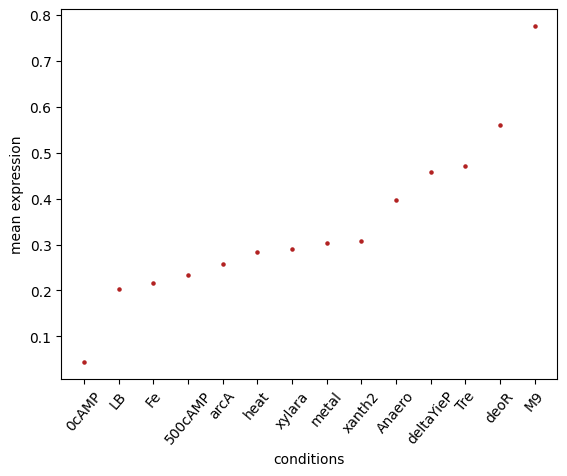

In [11]:
#Mean Expression in each environment, across all barcodes. 
GENE = 'ykgE'
wt_seq = gene_seq_to_array(GENE_WT_SEQ, NT_MAP)

GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]
nbases = len(GENE_WT_SEQ)
wildtype_genes_df.head()
# Convert data into numpy arrays
wt_seq = gene_seq_to_array(GENE_WT_SEQ, NT_MAP)
exp = np.zeros(len(conditions))

for j in range(len(conditions)):
    promoters, counts_dna, counts_rna = get_sequence_arrays_and_counts(data_by_condition[conditions[j]])
    expression = counts_rna / (counts_rna + counts_dna)
    exp[j] = np.mean(expression)
        
sort = np.argsort(exp)
conditions_sort = [conditions[i] for i in sort]
exp_sort = [exp[i] for i in sort]
    
x = np.arange(len(conditions))
plt.xticks(ticks=np.arange(len(conditions)), labels=conditions_sort, rotation = 50)
plt.scatter(x, exp_sort, color = 'firebrick', s = 5)
plt.xlabel('conditions')
plt.ylabel('mean expression')

print(conditions_sort)



In [12]:
def generate_expression(COND, GENE):
    """
    Compute both wildtype expression and expression shift at basepair level resolution
    """
    GENE_WT_SEQ = WT_GENE_SEQUENCES[GENE]
    wildtype_genes_df.head()
    # Convert data into numpy arrays
    wt_seq = gene_seq_to_array(GENE_WT_SEQ, NT_MAP)
    promoters, counts_dna, counts_rna = get_sequence_arrays_and_counts(data_by_condition[COND])

    # Define expression as ratio of mRNA counts to total counts
    expression = counts_rna / (counts_rna + counts_dna)
    
    wt_avg_expression = compute_mean_wildtype_expression(
    promoters, expression, wt_seq
    )   
    xi = compute_mean_expression_shift(
    promoters, expression, wt_seq
    )
    return wt_avg_expression, xi

Compute expression per segment in each environment. 

(160, 14)


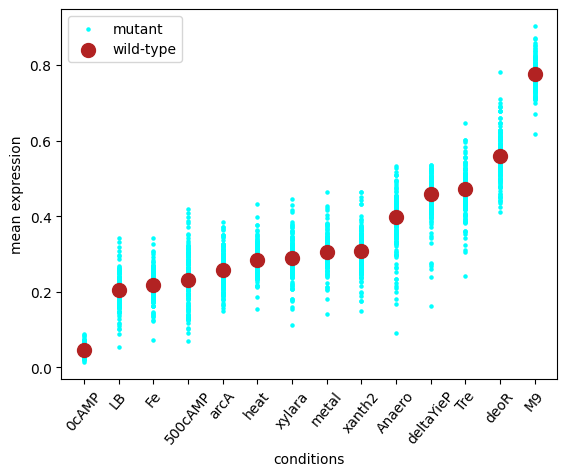

In [65]:
# Initialize variables
wt_exp = np.zeros(len(conditions))
xi_stack = np.zeros((len(conditions), 160))  # Assuming each generate_expression(COND, 'ykgE')[1] has 160 items

# Populate wt_exp and xi_stack
for i, COND in enumerate(conditions):
    wt_exp[i] = np.mean(generate_expression(COND, 'ykgE')[0])
    xi_stack[i] = generate_expression(COND, 'ykgE')[1]

# Transpose xi_stack to get 160 arrays each with 14 items
xi_split = xi_stack.T

# Verify the shape of xi_split
print(xi_split.shape)  # Should be (160, 14)

sort = np.argsort(wt_exp)
conditions_sort = [conditions[i] for i in sort]

wt_exp_sort = np.zeros(len(wt_exp))
for i in range(len(wt_exp)):
    wt_exp_sort[i] = wt_exp[sort[i]]

x = np.arange(len(conditions))
for i in range(len(xi_split)):
    temp = [xi_split[i][sort[j]] for j in range(len(sort))]
    if i ==0:
        plt.scatter(x, temp + wt_exp_sort, color='aqua', s=5, label = 'mutant')
    else:
        plt.scatter(x, temp + wt_exp_sort, color='aqua', s=5)


plt.xticks(ticks=np.arange(len(conditions)), labels=conditions_sort, rotation=50)
plt.scatter(x, wt_exp_sort, color='firebrick', s=100, label = 'wild-type')
plt.xlabel('conditions')
plt.ylabel('mean expression')
plt.legend()
plt.show()
